In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import time
from plotnine import *

# Basic Profiling

Here, we will develop a small code-base for testing the speed of converting between `networkx` and `numpy` arrays. These demonstrations will serve as the groundwork for whether the internal data structure of the package should be numpy matrices or just networkx objects, with appropriate conversion scripts held internally to handle operations such as converting between different edge types or optionally for select algorithms to internally convert to adjacency matrices. Using `networkx` objects gives us the benefit of not having to manually keep track of useful metadata such as graphs with richly attributed attributes, such as richly attributed vertices (ie, vertex labels, vertex names, vertex hierarchies) and/or richly attributed edges (ie, multiple weight functions for a single graph).

## Goal

The goal of these experiments is to identify whether, in a basic framework, a package based solely on `networkx` objects would incur a significant (>10 seconds) speed hit for using `networkx` graphs instead of defaulting to convert everything directly to `numpy` adjacency matrices. The results of these experiments will give us some basic direction moving forward with the formation of the package.

## Model

We will use the following simulations:

\begin{align*}
    \left(\mathcal{V}_n, \mathcal{E}_{n, p}, \mathcal{W}_{n, p}\right) ~ ER(n, p) \times \mathcal{N}(0, 1)
\end{align*}

where $ER(n, p)$ is the Erdos-Renyi model with $n$ vertices and $p$ probability of an edge existing. We know by the ER model that $\mathbb{E}\[|\mathcal{E}\] = n^2p$ where $\mathcal{E}$ is the number of edges in the graph. We also add a weight parameter where the weights are normally distributed with $\mu = 0$ and $\sigma = 1$, since many of the graphs in our case will be weighted in some form, and therefore this model will provide a more indicative performance for our real-world implementation. We will test for a dense setting where $p = 0.8$ and a sparse setting where $p = 0.2$.

## Algorithm

For simulating graphs from the $ER(n, p) \times \mathcal{N}(0, 1)$ model, we will use the following approach:
+ for p in (0.2, 0.8):
  + for n in logspace(3, 10, len=10):
    + A = empty $n \times n$ numpy array
    + sample at random $n^2p$ indices from $A$, and assign each of these points weight $\mathcal{N}(0, 1)$
    + convert $A$ to a `networkx` graph `G` in time $t_\rightarrow$
    + measure the time to convert `G` back to a `numpy` matrix in time $t_\leftarrow$
    + record $t_{\rightarrow}$ and $t_{\leftarrow}$
    + repeat $z$ times

In [2]:
ns = np.ceil(np.logspace(6, 11, num=10, base=2.0)).astype(int)
ps = [0.2, 0.8]
z = 20
tar = []; nar = []; par = []; zar = []; directions = []

for p in ps:
    print("p: {:.2f}".format(p))
    for n in ns:
        print("n: {:d}".format(n))
        for i in range(0, z):
            if (i%10 == 0):
                print("i: {:d}".format(i))
            A = np.zeros((n, n))
            nedge = int(round(n*n*p))
            np.put(A, np.random.choice(np.arange(0, n*n), size=nedge, replace=False), np.random.normal(size=nedge))
            t = time.time()
            Gfor = nx.from_numpy_matrix(A)
            ftime = time.time() - t
            t = time.time()
            Aback = nx.to_numpy_matrix(Gfor)
            rtime = time.time() - t
            for (t, d) in zip([ftime, rtime], ['A -> G', 'G -> A']):
                tar.append(t); directions.append(d); nar.append(n); par.append(p); zar.append(i)

p: 0.20
n: 64
i: 0
i: 10
n: 95
i: 0
i: 10
n: 139
i: 0
i: 10
n: 204
i: 0
i: 10
n: 299
i: 0
i: 10
n: 439
i: 0
i: 10
n: 646
i: 0
i: 10
n: 949
i: 0
i: 10
n: 1394
i: 0
i: 10
n: 2048
i: 0
i: 10
p: 0.80
n: 64
i: 0
i: 10
n: 95
i: 0
i: 10
n: 139
i: 0
i: 10
n: 204
i: 0
i: 10
n: 299
i: 0
i: 10
n: 439
i: 0
i: 10
n: 646
i: 0
i: 10
n: 949
i: 0
i: 10
n: 1394
i: 0
i: 10
n: 2048
i: 0
i: 10


In [3]:
results = pd.DataFrame({'time': tar, 'direction': directions, 'n': nar, 'p': par, 'z': zar})
results['direction'] = results['direction'].astype('category')
results['p'] = results['p'].astype('category')

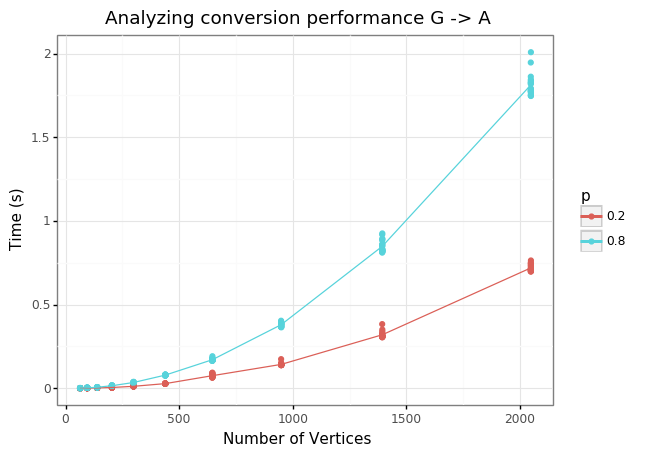

<ggplot: (-9223363275226205885)>

In [4]:
(ggplot(results.loc[results['direction'] == 'G -> A'], aes(x='n', y='time', color='p', group='p')) + 
 geom_jitter() +
 stat_summary(fun_data='mean_cl_boot', geom='line') +
 theme_bw() +
 xlab("Number of Vertices") +
 ylab("Time (s)") +
 ggtitle("Analyzing conversion performance G -> A"))

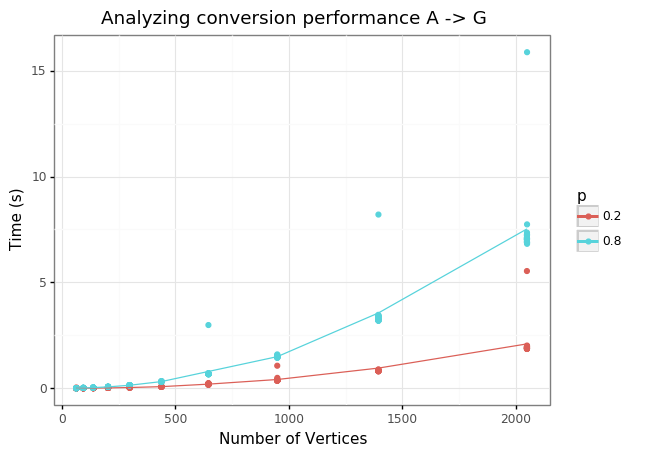

<ggplot: (8761090886555)>

In [5]:
(ggplot(results.loc[results['direction'] == 'A -> G'], aes(x='n', y='time', color='p', group='p')) + 
 geom_jitter() +
 stat_summary(fun_data='mean_cl_boot', geom='line') +
 theme_bw() +
 xlab("Number of Vertices") +
 ylab("Time (s)") +
 ggtitle("Analyzing conversion performance A -> G"))